In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [3]:
# q_in, q_switch, q_out1, q_out2
EJs = [21, 20, 22, 21.5]
ECs = [0.25, 0.35, 0.35, 0.28]
gs = [0.1, 0.1, 0.1] # g12, g23, g24
# EJs = [22, 21, 24, 23]
# ECs = [0.25, 0.4, 0.4, 0.28]
# gs = [0.15, 0.15, 0.15] # g12, g23, g24
cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print(qubit_freqs[0], qubit_freqs[1], qubit_freqs[2], qubit_freqs[3])
print(alphas[0], alphas[1], alphas[2], alphas[3])

6.219955176682236 7.114505318471956 7.480762973458866 6.647033320874119
-0.2765666000150251 -0.3976349542294244 -0.3947192737976515 -0.3114706721669016


In [4]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS

# qram.check_state_mapping(n=3)

In [5]:
# times = np.linspace(0, 650, 200)
# times = np.linspace(0, 1450, 400)
times = np.linspace(0, 200, 200)
# times = np.linspace(0, 10, 100)

seq = PulseSequence(start_time=0)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.04)
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12) # repeat of pulse 0
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.18)

# seq.wait(50)

# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.18)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12) # repeat of pulse 0
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.04)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12)

qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12)

# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.03)
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.04)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.06)

# seq.wait(50)

# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.06)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.04)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.03)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)

init overlap 0.7079453642843581
positive n 1 wd -48.61264560369273 wd_res 0.001 overlap 0.7079453657951069
positive n 2 wd -48.61164560369272 wd_res 0.001 overlap 0.7079453673057203
positive n 3 wd -48.610645603692724 wd_res 0.001 overlap 0.7079453688161975
positive n 4 wd -48.60964560369273 wd_res 0.001 overlap 0.7079453703265381
positive n 5 wd -48.60864560369272 wd_res 0.001 overlap 0.7079453718367449
positive n 6 wd -48.607645603692724 wd_res 0.001 overlap 0.7079453733468147
positive n 7 wd -48.606645603692726 wd_res 0.001 overlap 0.7079453748567492
positive n 8 wd -48.60564560369272 wd_res 0.001 overlap 0.707945376366547
positive n 9 wd -48.604645603692724 wd_res 0.001 overlap 0.7079453778762117
positive n 10 wd -48.603645603692726 wd_res 0.001 overlap 0.7079453793857375
positive n 11 wd -48.60264560369272 wd_res 0.001 overlap 0.7079453808951287
positive n 12 wd -48.601645603692724 wd_res 0.001 overlap 0.7079453824043844
positive n 13 wd -48.600645603692726 wd_res 0.001 overlap 0.

In [6]:
7.562031562144199*2*np.pi

47.51364560369272

[-7.721186505236094]


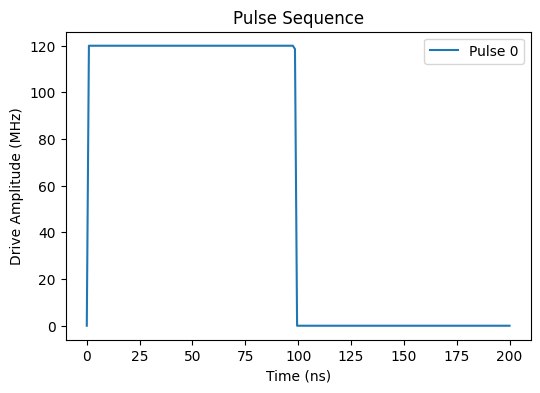

In [7]:
envelope_seq = seq.get_envelope_seq()
print(seq.pulse_freqs)
for i in range(len(envelope_seq)):
    plt.plot(times, [envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [8]:
# incl_dissipation = True
incl_dissipation = False

T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

c_ops = [
    np.sqrt(1/T1)*qram.a,
    np.sqrt(1/T1)*qram.b,
    np.sqrt(1/T1)*qram.c,
    np.sqrt(1/T1)*qram.d,
]

In [9]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(1/2) * qram.state('eggg') + np.sqrt(1/2) * qram.state('eegg') # QRAM start

# print(seq.get_pulse_str())

if incl_dissipation:
    full_result = qt.mcsolve(qram.H_solver_str(seq), psi0, times, c_ops, progress_bar=True, options=qt.Options(nsteps=10000))
    result = np.sum(full_result.states, axis=0)/full_result.ntraj
else:
    # result = qt.mesolve(qram.H_solver(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=10000)).states
    result = qt.mesolve(qram.H_solver_str(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=12000)).states

10.0%. Run time:   2.31s. Est. time left: 00:00:00:20
20.0%. Run time:   4.81s. Est. time left: 00:00:00:19
30.0%. Run time:   7.96s. Est. time left: 00:00:00:18
40.0%. Run time:  11.09s. Est. time left: 00:00:00:16
50.0%. Run time:  14.35s. Est. time left: 00:00:00:14
60.0%. Run time:  17.61s. Est. time left: 00:00:00:11
70.0%. Run time:  20.86s. Est. time left: 00:00:00:08
80.0%. Run time:  24.14s. Est. time left: 00:00:00:06
90.0%. Run time:  27.33s. Est. time left: 00:00:00:03
Total run time:  30.33s


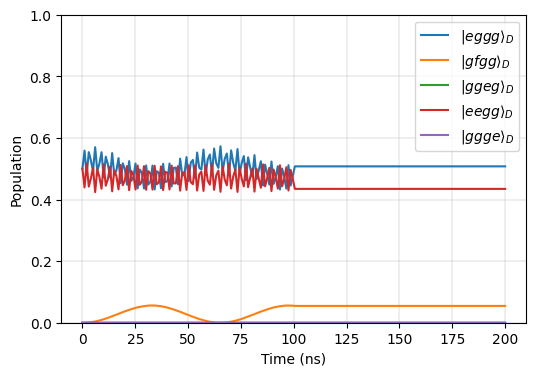

In [10]:
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')

prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]

plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [1]*len(times), 'k--', linewidth=0.5)
plt.legend()
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
plt.grid(linewidth=0.3)
plt.show()

In [11]:
T = 700 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                sum_psi += np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
print('Sum probabilities:', sum_psi)
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                if prob > 0.01: print(qram.level_nums_to_name([i1, i2, i3, i4]), prob)

Sum probabilities: 1.0006509685847333
Non-zero levels:
gfgg 0.054547450344019595
eggg 0.5076415377207798
eegg 0.43451746718873613


In [12]:
print('want', qram.get_wd('eggg', 'eegg')/2/np.pi)
print('resonant to', qram.get_wd('ggeg', 'geeg')/2/np.pi)
print('2 photon transition to', qram.get_wd('eggg', 'efgg')/2/np.pi)

TypeError: get_wd() missing 1 required positional argument: 'amp'

In [ ]:
print('want', qram.get_wd('gfgg', 'ggeg')/2/np.pi)
print(qram.get_wd('eegg', 'eege')/2/np.pi)

want 6.790158176784276
-6.801440393632177
